Running on computing device: cpu
Graph Created: torch.Size([100, 100]) nodes. Bridge at (0,99)
Bridge Weight: 0.00100 (Hidden Needle)

--- Bridge Score Comparison ---
H2O Score (Magnitude): 0.00100 (Very Low -> Will be Pruned)
CAB Score (Curvature): -85.71  (Very Negative -> Will be Kept)
Sparsity 50% -> H2O Found: True | CAB Found: True
Sparsity 80% -> H2O Found: False | CAB Found: True
Sparsity 90% -> H2O Found: False | CAB Found: True
Sparsity 95% -> H2O Found: False | CAB Found: True
Sparsity 98% -> H2O Found: False | CAB Found: True
Sparsity 99% -> H2O Found: False | CAB Found: True


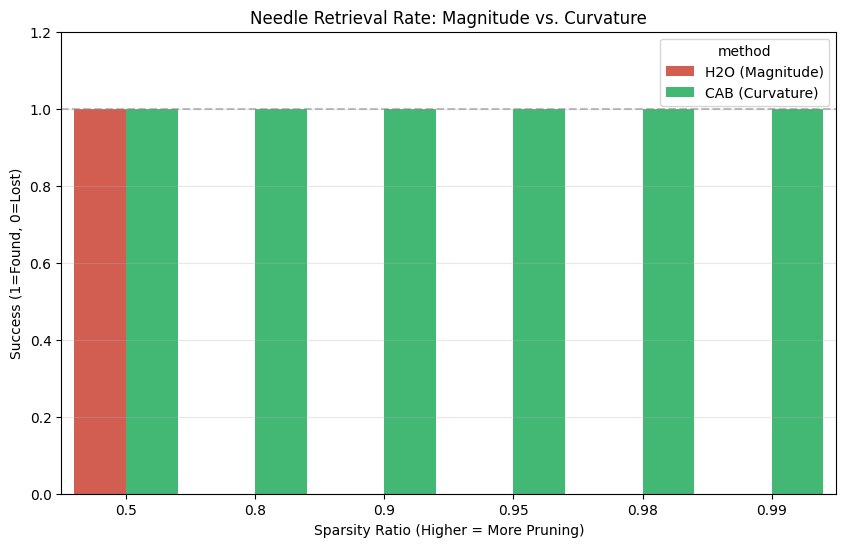

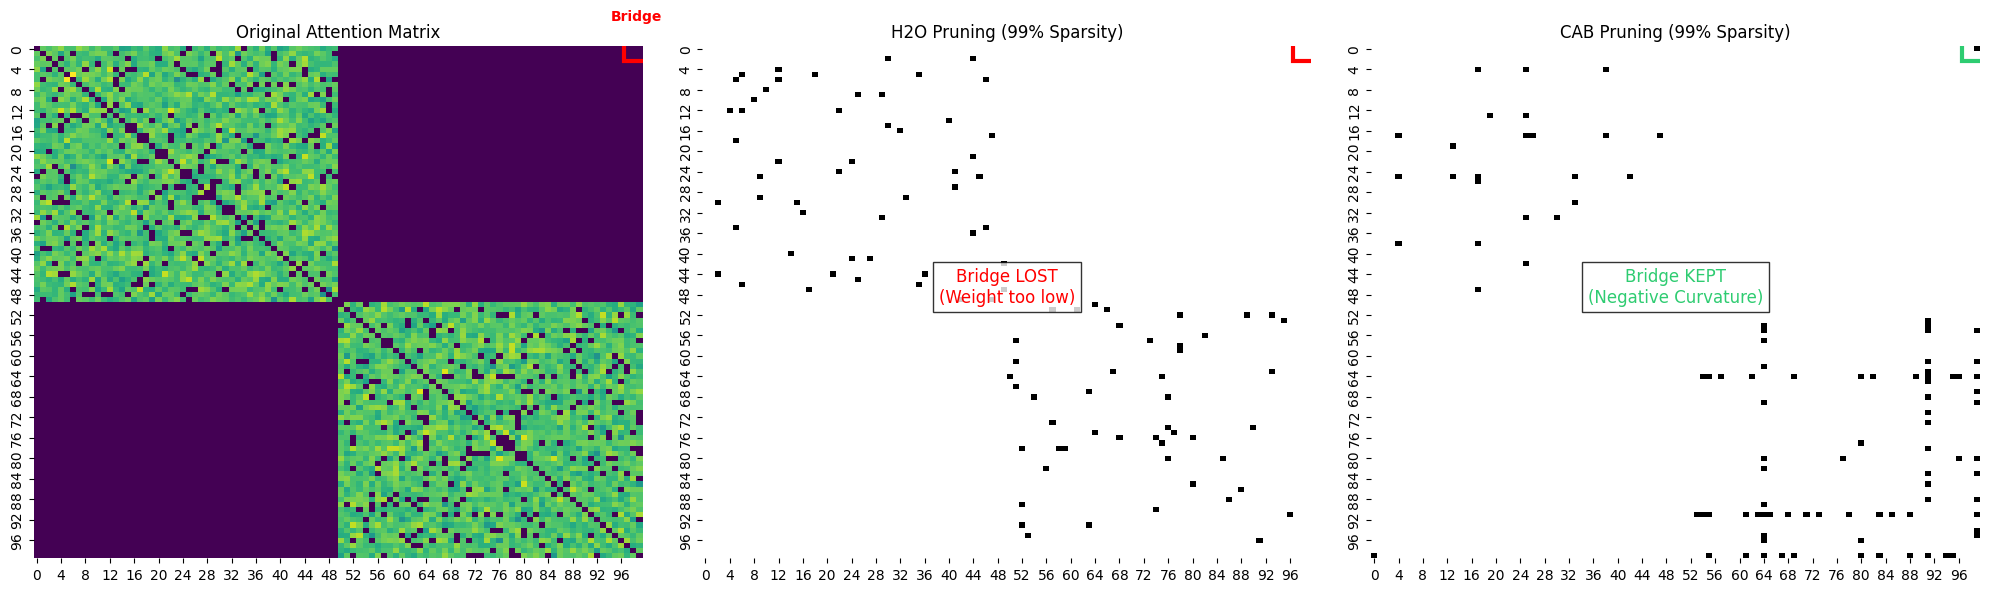

In [1]:
# @title Experiment 1: The "Hidden Bridge" Test (FRC vs. H2O)
# @markdown This script validates the hypothesis: **Forman-Ricci Curvature can detect topologically critical "bridges" even when their attention weights are vanishingly small.**

import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Added for easier plotting

# ==========================================
# 0. Setup & Config
# ==========================================
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on computing device: {device}")

# ==========================================
# 1. Data Generation: Stochastic Block Model
# ==========================================
def generate_synthetic_problem(
    num_nodes: int = 100,
    block_size: int = 50,
    intra_prob: float = 0.9,  # Very dense communities
    bridge_weight: float = 0.001,  # The "Needle": Extremely weak attention score
    intra_weight_mean: float = 1.0, # Strong attention inside communities
    intra_weight_std: float = 0.1
):
    """
    Creates a graph with two dense clusters (Community A & B).
    They are connected ONLY by a single edge (0 -> 99) with very low weight.
    """
    # 1. Generate Topology using NetworkX
    sizes = [block_size, block_size]
    probs = [[intra_prob, 0.0], [0.0, intra_prob]] # 0.0 inter-block prob
    G = nx.stochastic_block_model(sizes, probs, seed=42)

    # 2. Convert to Weighted Adjacency Tensor
    adj = torch.zeros((num_nodes, num_nodes), device=device)
    
    # Fill intra-community edges with high random weights (simulating "Haystack")
    for u, v in G.edges():
        w = np.random.normal(intra_weight_mean, intra_weight_std)
        w = np.clip(w, 0.1, 2.0) # Ensure positive
        adj[u, v] = w
        adj[v, u] = w # Undirected for this base test

    # 3. Insert the "Needle" (Weak Bridge)
    # Connect start of Block A to end of Block B
    u_bridge, v_bridge = 0, num_nodes - 1
    adj[u_bridge, v_bridge] = bridge_weight
    adj[v_bridge, u_bridge] = bridge_weight
    
    return adj, (u_bridge, v_bridge)

# ==========================================
# 2. The Geometry Kernel: Forman-Ricci
# ==========================================
def compute_forman_ricci_curvature(adj: torch.Tensor) -> torch.Tensor:
    """
    Computes the Augmented Forman-Ricci Curvature for a weighted graph.
    
    Theory:
    F(e_ij) ~ 4*w_ij - (Sum of weights incident to i) - (Sum of weights incident to j) 
              + (Triangles contribution)
    """
    N = adj.shape
    
    # 1. Node Strength (Weighted Degree)
    node_strength = torch.sum(adj, dim=1)
    
    # 2. Broadcast Strengths to Edges
    S_i = node_strength.unsqueeze(1).expand(*N)
    S_j = node_strength.unsqueeze(0).expand(*N)
    
    # 3. Compute "Base" Curvature (Bottleneck Term)
    # If S_i and S_j are large (hubs) and w_ij is small, this becomes VERY NEGATIVE.
    frc = 4 * adj - S_i - S_j
    
    # 4. Compute Triangles (Clustering Term)
    # A @ A gives count of paths of length 2. 
    triangles = torch.matmul(adj, adj)
    
    # Add triangle support. High triangle count = High Redundancy = Higher Curvature
    frc = frc + 3.0 * triangles
    
    # 5. Masking: Curvature is only defined for existing edges
    edge_mask = adj > 0
    frc = frc * edge_mask.float()
    
    # Assign a default high value to non-edges so they aren't selected 
    # when we look for "most negative" (lowest values)
    frc[~edge_mask] = 1000.0 
    
    return frc

# ==========================================
# 3. Pruning Logic
# ==========================================
def get_topk_mask(scores: torch.Tensor, sparsity: float, largest: bool = True) -> torch.Tensor:
    """
    Returns a binary mask retaining top-k edges.
    - largest=True (H2O): Keeps edges with HIGHEST scores (Magnitude).
    - largest=False (CAB): Keeps edges with LOWEST scores (Most Negative Curvature).
    """
    N = scores.shape
    flat_scores = scores.flatten()
    
    # Calculate k (number of edges to KEEP)
    # We base this on the total size for simplicity in this synthetic test
    k = int((1.0 - sparsity) * (N[0] * N[1]))
    if k < 1: k = 1
    
    if largest:
        # Keep Top-K Highest (Standard Attention)
        val, _ = torch.topk(flat_scores, k)
        threshold = val[-1]
        mask = scores >= threshold
    else:
        # Keep Top-K Lowest (Curvature: Most Negative = Most Important Bridge)
        val, _ = torch.topk(flat_scores, k, largest=False)
        threshold = val[-1]
        mask = scores <= threshold
        
    return mask

# ==========================================
# 4. Run Experiment
# ==========================================
def run_experiment():
    # Parameters
    sparsities = [0.5, 0.8, 0.9, 0.95, 0.98, 0.99]
    
    # 1. Generate Data
    adj, (u_bridge, v_bridge) = generate_synthetic_problem()
    
    print(f"Graph Created: {adj.shape} nodes. Bridge at ({u_bridge},{v_bridge})")
    print(f"Bridge Weight: {adj[u_bridge, v_bridge].item():.5f} (Hidden Needle)")
    
    # 2. Compute Metrics
    # Metric A: Magnitude (Standard Attention)
    metric_h2o = adj.clone()
    
    # Metric B: Curvature (Our Method)
    metric_frc = compute_forman_ricci_curvature(adj)
    
    # Check the values for the bridge specifically
    b_mag = metric_h2o[u_bridge, v_bridge].item()
    b_curv = metric_frc[u_bridge, v_bridge].item()
    print(f"\n--- Bridge Score Comparison ---")
    print(f"H2O Score (Magnitude): {b_mag:.5f} (Very Low -> Will be Pruned)")
    print(f"CAB Score (Curvature): {b_curv:.2f}  (Very Negative -> Will be Kept)")
    
    # 3. Test Pruning
    # FIXED: Explicitly initializing lists with
    results = {
        'sparsity': [],
        'method': [],
        'retrieved': []
    }
    
    for sp in sparsities:
        # H2O Selection (Keep Largest Weights)
        mask_h2o = get_topk_mask(metric_h2o, sp, largest=True)
        success_h2o = mask_h2o[u_bridge, v_bridge].item()
        
        # FRC Selection (Keep Smallest/Most Negative Curvature)
        mask_frc = get_topk_mask(metric_frc, sp, largest=False)
        success_frc = mask_frc[u_bridge, v_bridge].item()
        
        # Log Data
        results['sparsity'].append(sp)
        results['method'].append("H2O (Magnitude)")
        results['retrieved'].append(int(success_h2o))
        
        results['sparsity'].append(sp)
        results['method'].append("CAB (Curvature)")
        results['retrieved'].append(int(success_frc))
        
        print(f"Sparsity {sp*100:.0f}% -> H2O Found: {success_h2o} | CAB Found: {success_frc}")

    return results, adj, mask_h2o, mask_frc, (u_bridge, v_bridge)

# ==========================================
# 5. Visualization
# ==========================================
# Run the experiment
data_dict, adj, mask_h2o, mask_frc, bridge_loc = run_experiment()

# Convert to DataFrame for Seaborn
df = pd.DataFrame(data_dict)

# A. Bar Plot of Success Rates
plt.figure(figsize=(10, 6))
sns.barplot(x='sparsity', y='retrieved', hue='method', data=df, palette=['#E74C3C', '#2ECC71'])
plt.title("Needle Retrieval Rate: Magnitude vs. Curvature")
plt.ylabel("Success (1=Found, 0=Lost)")
plt.xlabel("Sparsity Ratio (Higher = More Pruning)")
plt.ylim(0, 1.2)
plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
plt.grid(axis='y', alpha=0.3)
plt.show()

# B. Heatmap Visualization (at highest sparsity)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# 1. Ground Truth
sns.heatmap(adj.cpu().numpy(), ax=ax[0], cmap="viridis", cbar=False)
ax[0].set_title("Original Attention Matrix")
# Draw box around bridge
u, v = bridge_loc
rect = plt.Rectangle((v-2, u-2), 5, 5, fill=False, edgecolor='red', lw=3)
ax[0].add_patch(rect)
ax[0].text(v, u-5, "Bridge", color='red', ha='center', fontweight='bold')

# 2. H2O Result
sns.heatmap(mask_h2o.cpu().float().numpy(), ax=ax[1], cmap="Greys", cbar=False)
ax[1].set_title(f"H2O Pruning (99% Sparsity)")
rect = plt.Rectangle((v-2, u-2), 5, 5, fill=False, edgecolor='red', lw=3)
ax[1].add_patch(rect)
ax[1].text(50, 50, "Bridge LOST\n(Weight too low)", color='red', ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# 3. FRC Result
sns.heatmap(mask_frc.cpu().float().numpy(), ax=ax[2], cmap="Greys", cbar=False)
ax[2].set_title(f"CAB Pruning (99% Sparsity)")
rect = plt.Rectangle((v-2, u-2), 5, 5, fill=False, edgecolor='#2ECC71', lw=3)
ax[2].add_patch(rect)
ax[2].text(50, 50, "Bridge KEPT\n(Negative Curvature)", color='#2ECC71', ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()